In [20]:
import tools

In [21]:
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [22]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()
print(os.getenv("LANGSMITH_ENDPOINT"))

https://api.smith.langchain.com


In [23]:
%pip install -U langchain langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [24]:
import os

import os
from langchain.chat_models import init_chat_model



llm = init_chat_model(
    "azure_openai:gpt-4.1-nano",
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
    api_version="2024-12-01-preview"
)

agent_tools = [tools.get_all_plants, tools.get_bloom_data_whole]
llm_with_tools = llm.bind_tools(agent_tools)

In [26]:
def rename(newname):
    def decorator(f):
        f.__name__ = newname
        return f
    return decorator

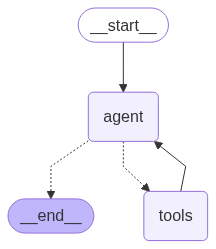

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import create_react_agent
import functools
from utils import make_specialist

make_specialist("erle")
        

In [28]:
plant = "erle"
blooming = functools.partial(tools.get_bloom_data_whole, plant=plant)

@rename(f"get_bloom_data_{plant}")

def get_bloom_data(year: int):
    """
    Get bloom data for the specified plant and year.

    Args:
        year (int): The year for which to retrieve bloom data.

    Returns:
        dict: A dictionary containing bloom data and additional information.
    """
    return blooming(year = year)

get_bloom_data(2023)

Tool invoked with plant=erle, year=2023, type=beginn
Tool invoked with plant=erle, year=2023, type=ende


{'begin_data': {'Jahr': {2: 2023},
  'Gebietsmittel': {2: '20.02. '},
  'Abweichung vom Mittel': {2: '-8 Tage'}},
 'ende_data': {'Jahr': {2: 2023},
  'Gebietsmittel': {2: '27.03. '},
  'Abweichung vom Mittel': {2: '0 Tage'}},
 'info_beginn': 'Tabelle mit den mittleren Beobachtungsterminen und den Abweichungen vom Mittel der Phase "Erle: Blüh-Beginn" im Gebiet Deutschland für verschiedene Jahre. Positive Abweichungen bedeuten, dass die Phase im entsprechendem Jahr später aufgetreten ist.',
 'info_ende': 'Tabelle mit den mittleren Beobachtungsterminen und den Abweichungen vom Mittel der Phase "Erle: Blüh-Ende im Beobachtungsgebiet" im Gebiet Deutschland für verschiedene Jahre. Positive Abweichungen bedeuten, dass die Phase im entsprechendem Jahr später aufgetreten ist.'}

In [ ]:
import os
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search.invoke("Was ist die Blütezeit von Sonnenblumen?")

{'query': 'Was ist die Blütezeit von Sonnenblumen?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Wann blühen Sonnenblumen? Alles Wichtige zur Blütezeit!',
   'url': 'https://www.pflanzen.schule/pflanzen/blumen/sonnenblume-bluetezeit/',
   'content': 'Die Vorzucht im Haus beschleunigt also die Ausbildung der Blüte der Sonnenblume und sorgt für eine frühere Blütezeit vom Stängel bis hin zu den Blättern und Blüten. Nicht nur der richtige Aussaat-Termin und der Pflanztermin sind somit ausschlaggebend für die Blütezeit der Sonnenblume, auch Faktoren, wie die Wärme, die Feuchtigkeit und der Nährstoffgehalt des Bodens sind wichtig! Die Blütezeit der Sonnenblume ist an den Zeitpunkt gebunden, an dem die Pflanze beginnt, zu keimen. Wer die Sonnenblumen im Haus vorzieht und bereits Keimlinge oder kleine Pflänzchen ins Beet oder in den Pflanzkübel setzt, kann sich mit einer höheren Wahrscheinlichkeit über eine frühere Blütezeit ab Juni bis Juli freuen.',


In [30]:
fallback_agent = create_react_agent(
    model=llm,
    tools=[web_search],
    prompt=(
        'Aufgaben:'
        '- Du bist ein Assistent, der Informationen über die Blütezeit von Pflanzen bereitstellt. Suche im Internet nach Informationen.'
        '- Antworte auf die Fragen in folgendme Format: Antworte in JSON und folge dem Schema: { "type": "object", "properties": { "response": { "type": "boolean" }, "reasoning": { "type": "string" } }, "required": [ "response", "reasoning" ] }'
    ),
    name="fallback_agent",
)

In [31]:
plants = tools.get_all_plants().split(" ")
print(plants)
#create specialists
specialists = {plant: make_specialist(plant) for plant in plants}
[specialist.name for specialist in specialists.values()]

['apfel', 'birke', 'erle', 'hasel', 'winterraps', 'winterroggen']


['apfel_agent',
 'birke_agent',
 'erle_agent',
 'hasel_agent',
 'winterraps_agent',
 'winterroggen_agent']

In [32]:
from langgraph_supervisor import create_supervisor
from langgraph_supervisor.handoff import create_forward_message_tool


forwarding_tool = create_forward_message_tool("supervisor") # The argument is the name to assign to the resulting forwarded message



supervisor = create_supervisor(
    model =llm,
    agents= list(specialists.values()) + [fallback_agent],
    prompt=(
        'Du bist ein Supervisor, der die Anfragen an Spezialisten weiterleitet. '
        'Anweisungen:'
        '- Wenn du eine Anfrage erhältst, leite sie an den passenden Spezialisten weiter. '
        '- Spezialisten sind benannt <plant>_agent, wobei <plant> der Name der Pflanze ist, für die Informationen benötigt werden.'
        '- Wenn kein passender Spezialist gefunden wird, leite die Anfrage an den fallback_agent weiter.'
        'Wichtig!:'
        '- Antworte auf keinen fall selbst!'
        '- Nutze statt zu antworten forwarding_tool, um die Antworten der spezialisten und des fallback_agents an __end__ weiterzuleiten.'
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
    tools=[forwarding_tool],
).compile()

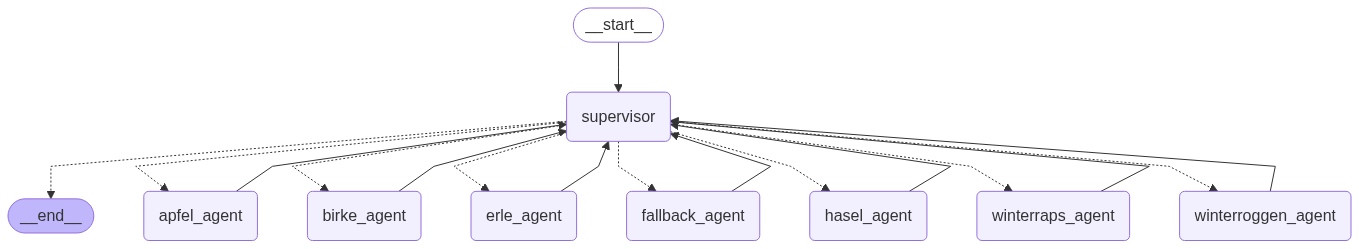

In [33]:


from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))



In [ ]:
# hide-cell
from langchain_core.messages import convert_to_messages
from utils import pretty_print_message, pretty_print_messages

In [ ]:
import json
from utils import get_tokens
#base_prompt = 'Antworte in JSON und folge dem Schema: { "type": "object", "properties": { "response": { "type": "boolean" }, "reasoning": { "type": "string" } }, "required": [ "response", "reasoning" ] }'
with open("datasets/dataset_24.json", "r") as file:
    dataset = json.load(file)


responses = []

for data in dataset:
    sentence = data["sentence"]
    prompt = [HumanMessage(content=sentence)]
    print(f"Processing: {sentence}")
    messages = supervisor.invoke({"messages": prompt})
    for m in messages['messages']:
        m.pretty_print()
    response = messages["messages"][-1].content
    cleaned_response = response.strip("```json").strip("```").strip()
    try:
        response_json = json.loads(cleaned_response)
    except json.JSONDecodeError as e:
        #sometimes the agent decides not to use the tool but to answer directly
        response = messages["messages"][-4].content
        cleaned_response = response.strip("```json").strip("```").strip()
        response_json = json.loads(cleaned_response)
    tokens = get_tokens(messages[:-3])
    responses.append({
        "id": data["id"],
        "plant": data["plant"],
        "city": data["city"],
        "date": data["date"],
        "sentence": sentence,
        "response": response_json["response"],
        "reasoning": response_json["reasoning"],
        "tokens": tokens
    })



with open("results/multiple_agent_24.json", "w") as file:
    json.dump(responses, file, indent=4)

Processing: Heute, am 11.04.2021, befinden wir uns in Berlin. Ist die Apfel gerade am Blühen?
Tool invoked with plant=apfel, year=2021, type=beginn
Tool invoked with plant=apfel, year=2021, type=ende
================================ Human Message =================================

Heute, am 11.04.2021, befinden wir uns in Berlin. Ist die Apfel gerade am Blühen?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_apfel_agent (call_D7WFH6uPnuxbs4eiAzSal6CU)
 Call ID: call_D7WFH6uPnuxbs4eiAzSal6CU
  Args:
================================= Tool Message =================================
Name: transfer_to_apfel_agent

Successfully transferred to apfel_agent
================================== Ai Message ==================================
Name: apfel_agent
Tool Calls:
  get_bloom_data_apfel (call_aVaNlbtG9Ub8tEYGcoNJGFvK)
 Call ID: call_aVaNlbtG9Ub8tEYGcoNJGFvK
  Args:
    year: 2021
================================= Tool 

In [43]:
messages["messages"][:-3]

[HumanMessage(content='Stellen wir uns vor, heute sei der 11.04.2021. Wir befinden uns in Köln. Blüht die Winterroggen aktuell?', additional_kwargs={}, response_metadata={}, id='a431352c-adf9-4c7b-ab50-9bb452ff42d3'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_u9aIQqJplsMhs9WLEQBOgvO2', 'function': {'arguments': '{}', 'name': 'transfer_to_winterroggen_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 381, 'total_tokens': 397, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_178c8d546f', 'id': 'chatcmpl-BlxWuil9QelHSLLZkYGIPB8ubgc1U', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity'

In [ ]:
messages = [HumanMessage(content="Angenommen heute wäre der 01.06.2020. Wir sind in Berlin. Hat die kastanie schon angefangen zu blühen?")]
messages = supervisor.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Angenommen heute wäre der 01.06.2020. Wir sind in Berlin. Hat die kastanie schon angefangen zu blühen?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_fallback_agent (call_NBCzjUOIjr0OWTAjqjYrFcoC)
 Call ID: call_NBCzjUOIjr0OWTAjqjYrFcoC
  Args:
================================= Tool Message =================================
Name: transfer_to_fallback_agent

Successfully transferred to fallback_agent
================================== Ai Message ==================================
Name: fallback_agent
Tool Calls:
  tavily_search (call_Up5mDflCjm6Lkyrf2ZIeBqmE)
 Call ID: call_Up5mDflCjm6Lkyrf2ZIeBqmE
  Args:
    query: Blütezeit Kastanie Berlin Juni
    search_depth: basic
================================= Tool Message =================================
Name: tavily_search

{"query": "Blütezeit Kastanie Berlin Juni", "follow_up_quest

In [ ]:
messages["messages"]

[HumanMessage(content='Angenommen heute wäre der 01.06.2020. Wir sind in Berlin. Hat die kastanie schon angefangen zu blühen?', additional_kwargs={}, response_metadata={}, id='9843bc89-0f41-42ae-8912-dc0087aeb3bf'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NBCzjUOIjr0OWTAjqjYrFcoC', 'function': {'arguments': '{}', 'name': 'transfer_to_fallback_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 379, 'total_tokens': 393, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_178c8d546f', 'id': 'chatcmpl-BlxOsu7USGSM7VFPOYBdC6pGZjBCy', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'saf